# Problem Statement
The process of classifying words into their parts of speech and labeling them accordingly their grammatical categories. These tags are then used to build relationships and connections between words in the NetworkX graph.

**Table of Content**

*   Imports
*   Data Preprocessing
*   POS Tagging

> *   Approach 1 : Stanford NLP
*   Approach 1 : Bidirectional LSTM
* Evaluate the POS Tagger


*   NetworkX Representation





# Imports

In [1]:
!pip install conllu

In [ ]:
!pip install arabic-reshaper python-bidi

In [79]:
import conllu
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display

#encode the corpus to numbers
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim


#build the lstm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import InputLayer

#performance evaluation
from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix
#save model
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

# Data Preprocessing

**Apply Preprocessing steps:**

1. remove numbers ( Arabic & English )

2. remove urls ( dependent on english chars )

3. remove english words

4. remove diacritics and tashkeel

5. normalize Charchters

6. remove special_chars

7. remove punctuation

8. whitespaces -> last thing

9. repeated charachters

In [13]:
def remove_numbers(text):
    # Replace Arabic numbers with empty string
    clean_text = re.sub(r'[٠١٢٣٤٥٦٧٨٩]', '', text)
    # Replace English numbers with empty string
    clean_text = re.sub(r'\d+', '', clean_text)
    return clean_text

raw_text = "٣٣ هاي 2023"
preprocessed_text = remove_numbers(raw_text)

print(f'Before: {raw_text}')
print(f'After : {preprocessed_text}')

Before: ٣٣ هاي 2023
After :  هاي 


In [14]:
def remove_links(text):
  URL_REGEXES = [
    r"(http(s)?:\/\/.)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)",
    r"@(https?|ftp)://(-\.)?([^\s/?\.#-]+\.?)+(/[^\s]*)?$@iS",
    r"http[s]?://[a-zA-Z0-9_\-./~\?=%&]+",
    r"www[a-zA-Z0-9_\-?=%&/.~]+",
    r"[a-zA-Z]+\.com",
    r"(?=http)[^\s]+",
    r"(?=www)[^\s]+",
    r"://",
  ]

  for reg in URL_REGEXES:
    text = re.sub(reg, '', text)
  return text

raw_text = "النكتة حلوة، بس هو مكانش عامل فولو ليه أصلا https://t.co/6lmlpseLk4	www.google.com"
preprocessed_text = remove_links(raw_text)

print(f'Before: {raw_text}')
print(f'After : {preprocessed_text}')

Before: النكتة حلوة، بس هو مكانش عامل فولو ليه أصلا https://t.co/6lmlpseLk4	www.google.com
After : النكتة حلوة، بس هو مكانش عامل فولو ليه أصلا 	


In [15]:
def remove_english(text):
    english_pattern = re.compile(r'[a-zA-Z]+')
    cleaned_text = re.sub(english_pattern, '', text)
    return cleaned_text

raw_text = "LeloSherif وانتي طيبة ي احلى لارا يا ملكة تويتر \nيارب انا وانتي حبيبتي الله يسعدك 	"
preprocessed_text = remove_english(raw_text)

print(f'Before: {raw_text}')
print(f'After : {preprocessed_text}')

Before: LeloSherif وانتي طيبة ي احلى لارا يا ملكة تويتر 
يارب انا وانتي حبيبتي الله يسعدك 	
After :  وانتي طيبة ي احلى لارا يا ملكة تويتر 
يارب انا وانتي حبيبتي الله يسعدك 	


In [16]:
def remove_diacritics(text):
    arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                            ـ    | # Tatwil/Kashida
                         """, re.VERBOSE)
    return re.sub(arabic_diacritics, '', text)

raw_text = "الــبسملة : ( بِسْمِ اللَّـهِ الرَّحْمَـٰنِ الرَّحِيمِ )"
preprocessed_text = remove_diacritics(raw_text)

print(f'Before: {raw_text}')
print(f'After : {preprocessed_text}')

Before: الــبسملة : ( بِسْمِ اللَّـهِ الرَّحْمَـٰنِ الرَّحِيمِ )
After : البسملة : ( بسم الله الرحمٰن الرحيم )


In [17]:
def normalize_chars(text):
    preprocessed_text = re.sub("[إأآا]", "ا", text)
    preprocessed_text = re.sub("ى", "ي", preprocessed_text)
    preprocessed_text = re.sub("ؤ", "ء", preprocessed_text)
    preprocessed_text = re.sub("ئ", "ء", preprocessed_text)
    preprocessed_text = re.sub("ة", "ه", preprocessed_text)
    preprocessed_text = re.sub("گ", "ك", preprocessed_text)
    preprocessed_text = re.sub("ڤ", "ف", preprocessed_text)
    preprocessed_text = re.sub("چ", "ج", preprocessed_text)
    preprocessed_text = re.sub("ژ", "ز", preprocessed_text)
    preprocessed_text = re.sub("پ", "ب", preprocessed_text)
    return preprocessed_text

raw_text = "ى آ ؤ ئ هيا"
preprocessed_text = normalize_chars(raw_text)

print(f'Before: {raw_text}')
print(f'After : {preprocessed_text}')

Before: ى آ ؤ ئ هيا
After : ي ا ء ء هيا


In [18]:
def remove_special_chars(text):
  '''
   The regular expression r'[^\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\d\s]+'
    matches any characters that are not in the specified range of
    Arabic Unicode characters (\u0600-\u06FF, \u0750-\u077F, and \u08A0-\u08FF),
    digits (\d), or whitespace (\s).
  '''
  special_chars_pattern = re.compile(r'[^\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\d# ]+')

  cleaned_text = re.sub(special_chars_pattern, ' ', text)
  return cleaned_text

raw_text = " مرحيا ðŸŒŽðŸŒ·"
preprocessed_text = remove_special_chars(raw_text)

print(f'Before: {raw_text}')
print(f'After : {preprocessed_text}')

Before:  مرحيا ðŸŒŽðŸŒ·
After :  مرحيا  


In [19]:
def remove_punctuation(text):
  pun = r"([!\"#$%\'\*\+,\.:;\-<=·>?@\^_ـ`{\|}~—٪’،؟`୍“؛”ۚ【»؛\s+«–…‘])"
  cleaned_text = re.sub(pun, ' ', text)
  return cleaned_text

# raw_text = "نسيت خبركم: طار #السبهان_هي"
raw_text = "   #تبيلس \n #الوكر_بيشجع_الفولورز\n #المواكيس_وفولورز_ببلاش\n#زعيم_تويتر_هيزودك"
preprocessed_text = remove_punctuation(raw_text)

print(f'Before: {raw_text}')
print(f'After : {preprocessed_text}')


Before:    #تبيلس 
 #الوكر_بيشجع_الفولورز
 #المواكيس_وفولورز_ببلاش
#زعيم_تويتر_هيزودك
After :     تبيلس    الوكر بيشجع الفولورز   المواكيس وفولورز ببلاش  زعيم تويتر هيزودك


In [20]:
def remove_extra_whitespaces(text):
    clean_text = re.sub(r'\s+', ' ', text)
    return clean_text.strip()

raw_text = "السلام عليكم    علـيـكم   "
preprocessed_text = remove_extra_whitespaces(raw_text)

print(f'Before: {raw_text}')
print(f'After : {preprocessed_text}')

Before: السلام عليكم    علـيـكم   
After : السلام عليكم علـيـكم


In [21]:
def remove_repeated_chars(text):
    pattern = re.compile(r"(.)\1{2,}")
    clean_text = pattern.sub(r"\1\1", text)
    return clean_text

raw_text = " اللللي بتااااااااااااااع  اللله اناااااااا "
preprocessed_text = remove_repeated_chars(raw_text)

print(f'Before: {raw_text}')
print(f'After : {preprocessed_text}')

Before:  اللللي بتااااااااااااااع  اللله اناااااااا 
After :  اللي بتااع  الله اناا 


In [22]:
def Pre_Processing(text):

  #numbers
  text = remove_numbers(text)

  #links
  text = remove_links(text)

  # English
  text= remove_english(text)

  #tashkel
  text=remove_diacritics(text)

  #normalizeChars
  text=normalize_chars(text)

  # special chars
  text=remove_special_chars(text)

  # punctuation
  text=remove_punctuation(text)

  #white_space
  text = remove_extra_whitespaces(text)

  #repeated charachters
  text = remove_repeated_chars(text)

  return text

# POS Tagging

## Approach 1 : Stanza
Stanza (formerly known as StanfordNLP) is a Python library developed by Stanford that provides state-of-the-art pre-trained models for a variety of natural language processing tasks, including POS tagging. Stanza is known for its easy integration and high-quality linguistic annotations.

In [53]:
!pip install stanza

In [55]:
import stanza
print(stanza.__version__)

stanza.download('ar')

# Initialize the stanza Arabic pipeline for POS tagging
nlp = stanza.Pipeline("ar", processors="tokenize,pos")

1.5.0


INFO:stanza:Downloading default packages for language: ar (Arabic) ...
INFO:stanza:File exists: /root/stanza_resources/ar/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: ar (Arabic):
| Processor | Package |
-----------------------
| tokenize  | padt    |
| mwt       | padt    |
| pos       | padt    |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Done loading processors!


In [77]:
# Sample Arabic sentence
article = """
              توظف سايشيلد مهنيين رقميين على مستوى عالمي يتمتعون بمعرفة وخبرة متطورة.
              خبرتنا الواسعة في المجال الرقمي تجعلنا الخيار الأفضل لاحتياجات شركتك ،
              ويسمح لنا تركيزنا على المجالات المتخصصة للغاية بتقديم خدمات استشارية فائقة تعد الأفضل في السوق.
              نحن ملتزمون بالعمل الجاد من أجل مرافقة عملائنا لتحقيق أهدافهم النهائية.
          """

# Process the sentence
PreProcessed_text = Pre_Processing(article)
doc = nlp(PreProcessed_text)

# Extract words and their POS tags
pos_tags = [(word.text, word.upos) for sent in doc.sentences for word in sent.words]

In [16]:
print(pos_tags)

[('توظف', 'VERB'), ('سايشيلد', 'X'), ('مهنيين', 'ADJ'), ('رقميين', 'ADJ'), ('علي', 'ADP'), ('مستوي', 'NOUN'), ('عالمي', 'ADJ'), ('يتمتعون', 'VERB'), ('ب', 'ADP'), ('معرف', 'NOUN'), ('ه', 'PRON'), ('و', 'CCONJ'), ('خبر', 'NOUN'), ('ه', 'PRON'), ('متطور', 'ADJ'), ('ه', 'PRON'), ('خبرة', 'NOUN'), ('نا', 'PRON'), ('الواسع', 'ADJ'), ('ه', 'PRON'), ('في', 'ADP'), ('المجال', 'NOUN'), ('الرقمي', 'ADJ'), ('تجعل', 'VERB'), ('نا', 'PRON'), ('الخيار', 'NOUN'), ('الافضل', 'ADJ'), ('ل', 'ADP'), ('احتياجات', 'NOUN'), ('شركة', 'NOUN'), ('ك', 'PRON'), ('و', 'CCONJ'), ('يسمح', 'VERB'), ('ل', 'ADP'), ('نا', 'PRON'), ('تركيز', 'NOUN'), ('نا', 'PRON'), ('علي', 'ADP'), ('المجالات', 'NOUN'), ('المتخصص', 'ADJ'), ('ه', 'PRON'), ('ل', 'ADP'), ('الغايه', 'NOUN'), ('ب', 'ADP'), ('تقديم', 'NOUN'), ('خدمات', 'NOUN'), ('استشاري', 'NOUN'), ('ه', 'PRON'), ('فاءق', 'NOUN'), ('ه', 'PRON'), ('تعد', 'VERB'), ('الافضل', 'ADJ'), ('في', 'ADP'), ('السوق', 'NOUN'), ('نحن', 'PRON'), ('ملتزمون', 'ADJ'), ('ب', 'ADP'), ('العمل', '

## Approach : Bi directional LSTM model (Bi-LSTM)
Through searching I found the stat-of-art for this task is **Meta BiLSTM (Bohnet et al., 2018)** whith accuracy 97.96 so let's try Bidirectional LSTM which is a sequential labeling classifier

### Read Data
* I will use in LSTM training Arabic PUD [github](https://github.com/UniversalDependencies/UD_Arabic-PUD) Taken from [Universal Dependencies](https://universaldependencies.org/)
* Uses articles from Wikipedia(W) and the news(N)
* Data is sequential (sequence of words) therefore using a sequence-labeling model is preferred



In [5]:
with open("/content/ar_pud-ud-test.conllu", mode="r", encoding="utf-8") as data:

    #read the file contents and assign under 'annotations'
    annotations=data.read()

#check the type of the resulting object
print(type(annotations))
annotations[1:1000]

<class 'str'>


' newdoc id = n01001\n# sent_id = n01001011\n# text = كتبت كوري شولمان, المساعدة الخاصة لأوباما في تدوينة نشرتها يوم الإثنين: "فيما الكثير من عمليات الانتقال الرقمي غير مسبوقة في الولايات المتحدة, فإن الانتقال السلمي للسلطة سبق له أن حدث".\n# original_text = كتبت كوري شولمان, المساعدة الخاصة لأوباما في تدوينة نشرتها يوم الإثنين: "فيما الكثير من عمليات الانتقال الرقمي غير مسبوقة في الولايات المتحدة, فإن الانتقال السلمي للسلطة سبق له أن حدث".\n# text_en = “While much of the digital transition is unprecedented in the United States, the peaceful transition of power is not,” Obama special assistant Kori Schulman wrote in a blog post Monday.\n1\tكتبت\tكَتَب\tVERB\tVBC\tAspect=Perf|Gender=Fem|Number=Sing|Person=3|Tense=Past|Voice=Act\t0\troot\t_\tLId=كَتَب-ُ_1\n2\tكوري\tكوري\tPROPN\tNNP\tCase=Nom|Gender=Fem|Number=Sing\t1\tnsubj\t_\tLId=كوري_0\n3\tشولمان\tشولمان\tPROPN\tNNP\tGender=Masc|Number=Sing\t2\tflat\t_\tLId=شولمان_0|SpaceAfter=No\n4\t,\t,\tPUNCT\t,\t_\t5\tpunct\t_\tLId=,_0\n5\tالمساعد

In [6]:
#parse the string of annotations to sentences
sentences = conllu.parse(annotations)

In [7]:
print(type(sentences))
sentences[0].metadata #metadata is simply a dictionary type
#meta data has 5 keys:newdoc id ,sent_id,text,original_text,text_en

<class 'conllu.models.SentenceList'>


{'newdoc id': 'n01001',
 'sent_id': 'n01001011',
 'text': 'كتبت كوري شولمان, المساعدة الخاصة لأوباما في تدوينة نشرتها يوم الإثنين: "فيما الكثير من عمليات الانتقال الرقمي غير مسبوقة في الولايات المتحدة, فإن الانتقال السلمي للسلطة سبق له أن حدث".',
 'original_text': 'كتبت كوري شولمان, المساعدة الخاصة لأوباما في تدوينة نشرتها يوم الإثنين: "فيما الكثير من عمليات الانتقال الرقمي غير مسبوقة في الولايات المتحدة, فإن الانتقال السلمي للسلطة سبق له أن حدث".',
 'text_en': '“While much of the digital transition is unprecedented in the United States, the peaceful transition of power is not,” Obama special assistant Kori Schulman wrote in a blog post Monday.'}

In [8]:
sentences[0][0]

{'id': 1,
 'form': 'كتبت',
 'lemma': 'كَتَب',
 'upos': 'VERB',
 'xpos': 'VBC',
 'feats': {'Aspect': 'Perf',
  'Gender': 'Fem',
  'Number': 'Sing',
  'Person': '3',
  'Tense': 'Past',
  'Voice': 'Act'},
 'head': 0,
 'deprel': 'root',
 'deps': None,
 'misc': {'LId': 'كَتَب-ُ_1'}}

### Create corpus

In [23]:
#create a corpus : list of dictionaries, each dict is a sentence and appling preprocessing
corpus=[]
list_pos=[]
list_words=[]
pos=[]
list_sentences=[]
for sentence in sentences:
    word_dict={}
    sentence_txt=sentence.metadata['text']
    print(sentence_txt)# example of no preprocessing varification
    re_pattern = re.compile(r'[a-zA-Z]+')
    if re_pattern.search(sentence_txt)== None:
        list_sentences.append(sentence_txt)
        pos_bfr=[]
        for w_indx in range(len(sentence)):
            word_str=Pre_Processing(sentence[w_indx]['form'])
            word_pos=sentence[w_indx]['upos']
            pos_bfr.append(word_pos)
            list_pos.append(word_pos)
            list_words.append(word_str)
            word_dict[w_indx]=[word_str,word_pos,sentence_txt,len(sentence_txt)]
        pos.append(pos_bfr)
        corpus.append(word_dict)

كتبت كوري شولمان, المساعدة الخاصة لأوباما في تدوينة نشرتها يوم الإثنين: "فيما الكثير من عمليات الانتقال الرقمي غير مسبوقة في الولايات المتحدة, فإن الانتقال السلمي للسلطة سبق له أن حدث".
بالنسبة إلى أولئك الذين يتابعون الانتقال الخاص بوسائل التواصل الاجتماعي في الكابيتول هيل, سيكون الأمر مختلفاً بعض الشيء.
لكن بعيداً عن كلامه السابق بشأن الحد من الهجرة, أعلن المرشح الجمهوري أنه كرئيس سيسمح "بأعدادٍ هائلة" من المهاجرين الشرعيين على أساس "نظام الجدارة".
قال للحشد الذي تجمع في أحد الملاعب الرياضية الخاصة بجامعة كارولينا الشمالية.
تمول النفقات الجديدة من خلال حساب كلينتون المصرفي الكبير.
إن ما تقوله وما تفعله... في الواقع, إنه أمرٌ لا يصدق.
الحد الأقصى المسموح به للشخص الواحد هو 5000 دولار.
في أوائل شهر تشرين الأول, استخدم الفريق الانتقالي ذات المكان للقاء جماعات الضغط التكنولوجية, بحضور ممثلين عن شركة "أوبر" وجمعية الفيلم الأمريكي وجمعية مستهلكي التكنولوجيا وغيرها.
كان من المقرر في الأصل أن يقام التجمع في نادي المتروبوليتان في واشنطن في شارع "إتش" الذي لا يبعد كثيراً.
لربما كان الزي الواجب

In [24]:
#report the info of the cleaned corpus
print("The corpus has {} sentences".format(len(corpus)))

The corpus has 998 sentences


In [25]:
#save the results in a dataframe
df_w = pd.DataFrame (list_words, columns = ['w_name'])
df = pd.DataFrame (list_pos, columns = ['tag_name'])
df_w.to_csv("word_list_cleaned.csv", encoding="utf-8")
df.to_csv("tag_list.csv", encoding="utf-8")

[Text(0, 0, '5553'),
 Text(0, 0, '3565'),
 Text(0, 0, '2219'),
 Text(0, 0, '2021'),
 Text(0, 0, '1747'),
 Text(0, 0, '1724'),
 Text(0, 0, '1294'),
 Text(0, 0, '647'),
 Text(0, 0, '565'),
 Text(0, 0, '401'),
 Text(0, 0, '368'),
 Text(0, 0, '187'),
 Text(0, 0, '185'),
 Text(0, 0, '165'),
 Text(0, 0, '30'),
 Text(0, 0, '1')]

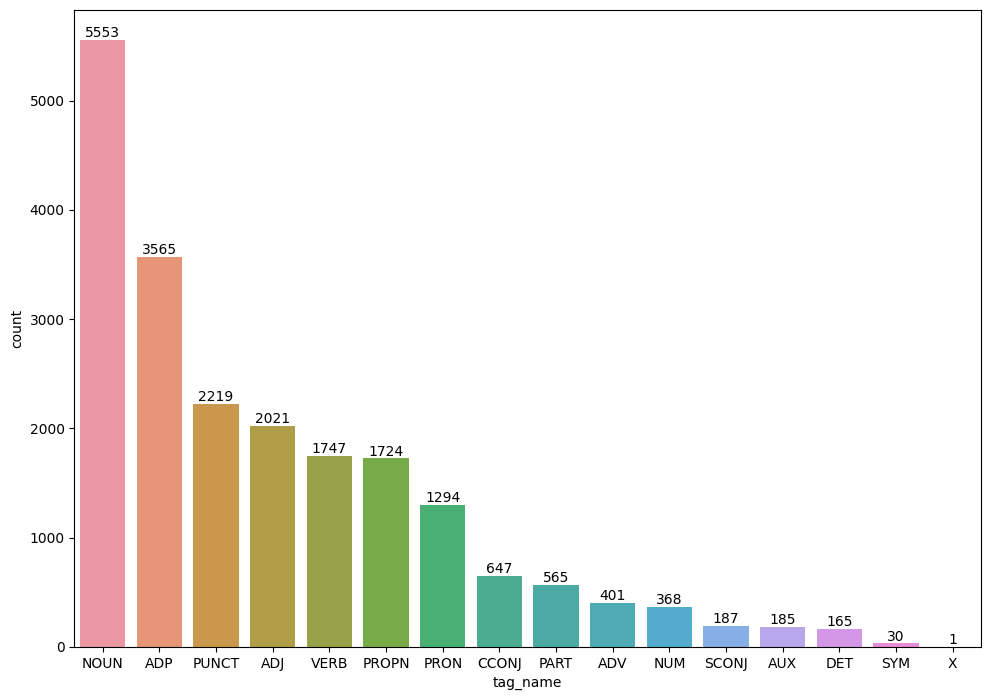

In [26]:
#plot the found tags with popularity of each in the corpus
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
ax = sns.countplot(x=df['tag_name'],
                   order=df['tag_name'].value_counts(ascending=False).index);

abs_values = df['tag_name'].value_counts(ascending=False).values

ax.bar_label(container=ax.containers[0], labels=abs_values)

### Preprocessing of Input Text data
Inspired by this [article ](https://medium.com/@WaadTSS/how-to-use-arabic-word2vec-word-embedding-with-lstm-af93858b2ce)

**Preprocess the input text data**



> Step1: convert from text to natural numbers

> Step2: unify the length of sentences by padding with direction= left









In [27]:
def sentence_max_len(list_sentences):
    list_sentence_len=[]
    for sentence in list_sentences:
        list_sentence_len.append(len(sentence))
    return max(list_sentence_len)

**Encode sentences to numbers**

In [28]:
tkn= Tokenizer()
#read the corpus
tkn.fit_on_texts(list_sentences)

vocab_size=len(tkn.word_index)+1 #the size is including the padding

#encoding the corpus
enc_corpus=tkn.texts_to_sequences(list_sentences)

In [29]:
# look at first encoded data point

print("** Raw data point **", "\n", "-"*100, "\n")
print(list_sentences[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print(enc_corpus[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

كتبت كوري شولمان, المساعدة الخاصة لأوباما في تدوينة نشرتها يوم الإثنين: "فيما الكثير من عمليات الانتقال الرقمي غير مسبوقة في الولايات المتحدة, فإن الانتقال السلمي للسلطة سبق له أن حدث". 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

[1995, 406, 1996, 582, 39, 1997, 1, 1998, 1999, 49, 2000, 119, 75, 2, 2001, 234, 972, 26, 2002, 1, 134, 50, 76, 234, 2003, 2004, 2005, 301, 3, 181] 



In [30]:
print("- The LSTM input is type {} of sentences, \n- Each sentence is a list of {} each representing words\n- The number of sentences is {} \n "
      .format(type(enc_corpus),type(enc_corpus[0][0]),len(enc_corpus)))

- The LSTM input is type <class 'list'> of sentences, 
- Each sentence is a list of <class 'int'> each representing words
- The number of sentences is 998 
 


###Padding the shorter sentences
Compute maximum length of a sentence with the corpus

In [31]:
# check length of longest sentence
lengths = [len(seq) for seq in list_sentences]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 257


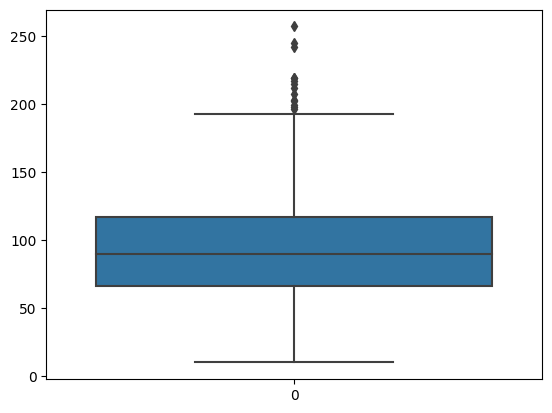

In [32]:
sns.boxplot(lengths)
plt.show()

**Use pad_sequences of keras with padding direction to the left**

In [33]:
max_len=sentence_max_len(list_sentences)
pad_corpus=pad_sequences(enc_corpus, maxlen=max_len, padding='post')
pad_corpus.shape

(998, 257)

###Label Encode the output
Label encode the tags

Preprocess the **output tags per sentence**

*   Step1: create a dictionary of tags where label encoding is done alphebatically

*   Step2: convert the tag text to tag number using dictionary

*   Step3: unify the length of output array by padding with direction= left, and value (tag_name=X, tag_value=15)

*   Step4: add 3rd dimension which represents the label encoding for each tag for each sentence
Note: forth step is done to fit the last layer of time-distributed of the Bi-LSTM system





In [34]:
output=pos
flat_output = sum(output, [])
# create a dictionary to map target from txt to int label
pos_keyword=list(set(flat_output))
#sort it alphabatically first element is the first in alphabetical order
pos_keyword=sorted(pos_keyword)
max_len=sentence_max_len(list_sentences)
padding_value = pos_keyword.index("X")
print("the fixed output length is {}, where the padding value of x is {}"
      .format(max_len,padding_value))


arr_r=len(output)
arr_c=max_len
#fill-in (pad) all the label matrix
encoded_target = np.full((arr_r,arr_c),padding_value, dtype=int)
for sentence_ind in range(len(output)):
    sentence=output[sentence_ind]
    for pos_ind in range(len(sentence)):
        indiv_pos=output[sentence_ind][pos_ind]
        target_label=pos_keyword.index(indiv_pos)
        encoded_target[sentence_ind][pos_ind]=target_label

the fixed output length is 257, where the padding value of x is 15


In [35]:
print(output[0])
print(encoded_target[0][:41])

['VERB', 'PROPN', 'PROPN', 'PUNCT', 'NOUN', 'ADJ', 'ADP', 'PROPN', 'ADP', 'NOUN', 'VERB', 'PRON', 'ADV', 'PROPN', 'PUNCT', 'PUNCT', 'ADP', 'NOUN', 'ADP', 'NOUN', 'NOUN', 'ADJ', 'PART', 'ADJ', 'ADP', 'PROPN', 'ADJ', 'PUNCT', 'PART', 'PART', 'NOUN', 'ADJ', 'ADP', 'NOUN', 'VERB', 'ADP', 'PRON', 'ADP', 'VERB', 'PUNCT', 'PUNCT']
[14 10 10 11  6  0  1 10  1  6 14  9  2 10 11 11  1  6  1  6  6  0  8  0
  1 10  0 11  8  8  6  0  1  6 14  1  9  1 14 11 11]


In [36]:
encoded_target.shape

(998, 257)

**One-Hot-Encode The Output**

Format of the output (sentences, max_sentence_len, number_of_tags)

In [37]:
new_row=encoded_target.shape[0]
new_col=encoded_target.shape[1]
num_new_col=len(pos_keyword)
one_hot_encoded_col=np.zeros((new_row,new_col,num_new_col))
#cols 16, shape =(998, 257)

for sentence_ind in range(len(encoded_target)):
    sentence = encoded_target[sentence_ind]
    for word_ind in range(len(sentence)):

        #create the on-hot-encoding
        w_1hotenc = np.zeros((1,num_new_col))
        high_ind=sentence[word_ind-1]
        w_1hotenc[0][high_ind]=1

        #modify the target label matrix per word
        one_hot_encoded_col[sentence_ind][word_ind][:]=w_1hotenc

### Split the data into training and testing

*   Ratio : 85%training-15%testing

*   Split is done randomly with the ratio 85-15 using numpy library




In [38]:
total_samples=pad_corpus.shape[0]
train_samples=round(total_samples* 0.85)

indices = np.random.permutation(total_samples)
training_idx, test_idx = indices[:train_samples], indices[train_samples:]
train_x, test_x = pad_corpus[training_idx,:], pad_corpus[test_idx,:]
train_y, test_y = one_hot_encoded_col[training_idx,:], one_hot_encoded_col[test_idx,:]

### Create the LSTM Model
**Step1: Word Embedding**

Word embedding provides a dense representation of words and their relative meanings.

The word embedding technique used in this Task is N-Gram Word2Vec -SkipGram model from [aravec](https://github.com/bakrianoo/aravec) project trained on twitter data with vector size 300.

In [96]:
!gdown https://bakrianoo.ewr1.vultrobjects.com/aravec/full_grams_sg_300_twitter.zip

Downloading...
From: https://bakrianoo.ewr1.vultrobjects.com/aravec/full_grams_sg_300_twitter.zip
To: /content/full_grams_sg_300_twitter.zip
100% 3.32G/3.32G [01:09<00:00, 47.9MB/s]


In [97]:
import zipfile

# Path to the zip file
zip_file_path = '/content/full_grams_sg_300_twitter.zip'

# List the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_contents = zip_ref.namelist()

print("Contents of the zip file:")
for item in zip_contents:
    print(item)


Contents of the zip file:
full_grams_sg_300_twitter.mdl
full_grams_sg_300_twitter.mdl.trainables.syn1neg.npy
full_grams_sg_300_twitter.mdl.wv.vectors.npy


In [98]:
import zipfile

zip_file_path = "/content/full_grams_sg_300_twitter.zip"
extracted_folder = "/content/extracted_model"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)


In [1]:
from gensim.models import Word2Vec

model_path = "/content/extracted_model/full_grams_sg_300_twitter.mdl"
embedding_model = Word2Vec.load(model_path)


In [ ]:
#list of words in the dictionary
#embedding_model.wv.index_to_key

In [39]:
embeddings = {}
for word,vector in zip(embedding_model.wv.index_to_key,embedding_model.wv):
    coefs =[]
    coefs.append(vector)
    embeddings[word] = coefs
embeddings_weights = np.zeros((vocab_size, 300))
for word, i in tkn.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embeddings_weights[i] = embedding_vector[0]

### Create the model


In [40]:
def create_model():
    # define the model
    #output_dim=pad_corpus.shape[0]
    max_len=pad_corpus.shape[1]
    number_label_classes=len(pos_keyword)

    model = Sequential()
    model.add(Embedding(input_dim = vocab_size,output_dim=300,input_length = max_len,weights =[embeddings_weights],trainable=False))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))


    model.add(TimeDistributed(Dense(number_label_classes, activation='softmax')))

    #compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [41]:
# define the model
#output_dim=pad_corpus.shape[0]
max_len=pad_corpus.shape[1]
number_label_classes=len(pos_keyword)



model = Sequential()
model.add(Embedding(input_dim = vocab_size,output_dim=300,input_length = max_len,weights =[embeddings_weights],trainable=False))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64, return_sequences=True)))


model.add(TimeDistributed(Dense(number_label_classes, activation='softmax')))

#compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#summarize the model
model.summary()
#998 is the number of sentences, 257 is the embedding dimensions which is the maximum length
#1000 is 2 lstm of size 500 each in an opposite direction

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 257, 300)          2280900   
                                                                 
 bidirectional (Bidirectiona  (None, 257, 128)         186880    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 257, 128)         98816     
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 257, 16)          2064      
 ibuted)                                                         
                                                                 
Total params: 2,568,660
Trainable params: 287,760
Non-trainable params: 2,280,900
________________________________________

### Train the model

In [42]:
# fit the model
history=model.fit(train_x, train_y, validation_split=0.1,epochs=25, verbose=1)

Epoch 1/25
24/24 [==============================] - 17s 139ms/step - loss: 1.2982 - accuracy: 0.8887 - val_loss: 0.2341 - val_accuracy: 0.9343
Epoch 2/25
24/24 [==============================] - 1s 40ms/step - loss: 0.2276 - accuracy: 0.9325 - val_loss: 0.2134 - val_accuracy: 0.9355
Epoch 3/25
24/24 [==============================] - 1s 36ms/step - loss: 0.2107 - accuracy: 0.9336 - val_loss: 0.2056 - val_accuracy: 0.9355
Epoch 4/25
24/24 [==============================] - 1s 36ms/step - loss: 0.2055 - accuracy: 0.9354 - val_loss: 0.2026 - val_accuracy: 0.9392
Epoch 5/25
24/24 [==============================] - 1s 36ms/step - loss: 0.2030 - accuracy: 0.9374 - val_loss: 0.2005 - val_accuracy: 0.9392
Epoch 6/25
24/24 [==============================] - 1s 34ms/step - loss: 0.2014 - accuracy: 0.9373 - val_loss: 0.1989 - val_accuracy: 0.9390
Epoch 7/25
24/24 [==============================] - 1s 35ms/step - loss: 0.1997 - accuracy: 0.9373 - val_loss: 0.1976 - val_accuracy: 0.9389
Epoch 8/25


### Save & Load the trained model


In [43]:
model.save_weights("bilstm_model_aravec.h5")


In [44]:
loaded_model = create_model()
# Restore the weights
loaded_model.load_weights("bilstm_model_aravec.h5")

## Evaluate the POS Tagger

**LSTM Performance Evaluation**
* accuracy, recall, precision, and f1 measure,
* learning curve

In [45]:
loss,accuracy =model.evaluate(test_x, test_y)

5/5 [==============================] - 0s 32ms/step - loss: 0.1901 - accuracy: 0.9424


### Post-Processing
* Step1: round the predicted values to int (bcuz it is in the 1-hot-encoding format)
* Step2: convert from 1-hot-encoding format to label encoding
* Step3: convert from label encoding format to tag names

In [46]:
#Step1: round the predicted values to int (bcuz it is in the 1-hot-encoding format)
predict_y=model.predict(test_x)
predict_y=np.rint(predict_y)
predict_y=predict_y.astype(int)

5/5 [==============================] - 1s 26ms/step


In [47]:
#Step2: convert from 1-hot-encoding format to label encoding
#pos_keyword is list of tags as words
def reverse_1hotenc(onehotenc, pos_keyword):
    decoded = np.zeros((onehotenc.shape[0], onehotenc.shape[1]), dtype=int)  # Set dtype to int
    for sentence_ind in range(len(onehotenc)):
        sentence = onehotenc[sentence_ind]
        for word_ind in range(len(sentence)):
            onehotenc_label = onehotenc[sentence_ind][word_ind]
            label_index = np.where(onehotenc_label == 1)[0]
            if label_index.size > 0:
                decoded[sentence_ind][word_ind] = label_index[0]  # Use the integer index
    return decoded

test_y_decoded =reverse_1hotenc(test_y,pos_keyword)
predict_y_decoded =reverse_1hotenc(predict_y,pos_keyword)

In [48]:
# Step3: convert from label encoding format to tag names
def decode_labels(encoded_labels, pos_keyword):
    decoded_labels = []
    for sentence_labels in encoded_labels:
        decoded_sentence = [pos_keyword[label] for label in sentence_labels]
        decoded_labels.append(decoded_sentence)
    return decoded_labels

test_y_tags = decode_labels(test_y_decoded, pos_keyword)
predict_y_tags = decode_labels(predict_y_decoded, pos_keyword)

In [51]:
# Reversing the encoded sentences to original words
def decode_encoded_sentences(encoded_sentences, tokenizer):
    decoded_sentences = []
    for encoded_sentence in encoded_sentences:
        decoded_sentence = tokenizer.sequences_to_texts([encoded_sentence])[0]
        decoded_sentences.append(decoded_sentence)
    return decoded_sentences

# Reversing the one-hot encoded tags to original POS tags
def decode_one_hot(encoded_tags, pos_keywords):
    decoded_tags = []
    for sentence_tags in encoded_tags:
        decoded_sentence_tags = []
        for word_tags in sentence_tags:
            tag_index = np.argmax(word_tags)
            decoded_tag = pos_keywords[tag_index]
            decoded_sentence_tags.append(decoded_tag)
        decoded_tags.append(decoded_sentence_tags)
    return decoded_tags

# Decoding the test input sentences and their original POS tag sequences
decoded_test_input = decode_encoded_sentences(test_x, tkn)
decoded_test_tags = decode_one_hot(test_y, pos_keyword)

# Printing a few examples of decoded sentences and their tags
for i in range(5):
    print("Example:", i+1)
    print("Decoded Input Sentence:", decoded_test_input[i])
    print("Original POS Tags:", decoded_test_tags[i])
    print()

Example: 1
Decoded Input Sentence: ثم زحف فيليب لضرب أعدائه الجنوبيين
Original POS Tags: ['X', 'PART', 'NOUN', 'PROPN', 'ADP', 'NOUN', 'NOUN', 'PRON', 'ADJ', 'PUNCT', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X'

In [57]:
# Remove padding tags and keep only existing tags for the words
cleaned_test_tags = []
for sentence_tags in decoded_test_tags:
    cleaned_sentence_tags = [tag for tag in sentence_tags if tag != 'X']
    cleaned_test_tags.append(cleaned_sentence_tags)

# Printing the cleaned examples of decoded sentences and their tags
for i in range(5):
    print("Example:", i+1)
    print("Decoded Input Sentence:", decoded_test_input[i])
    print("Cleaned Original POS Tags:", cleaned_test_tags[i])
    print()


Example: 1
Decoded Input Sentence: ثم زحف فيليب لضرب أعدائه الجنوبيين
Cleaned Original POS Tags: ['PART', 'NOUN', 'PROPN', 'ADP', 'NOUN', 'NOUN', 'PRON', 'ADJ', 'PUNCT']

Example: 2
Decoded Input Sentence: لكن جمهورية الصين التي كانت قد تأسست حديثاً اعتبرت أن منغوليا جزءٌ من أراضيها
Cleaned Original POS Tags: ['PART', 'PROPN', 'PROPN', 'PRON', 'AUX', 'PART', 'VERB', 'ADV', 'VERB', 'SCONJ', 'PROPN', 'NOUN', 'ADP', 'NOUN', 'PRON', 'PUNCT']

Example: 3
Decoded Input Sentence: كان إليوت يحضر جنازة والده في اليوم الذي أقيم فيه السباق
Cleaned Original POS Tags: ['AUX', 'PROPN', 'VERB', 'NOUN', 'NOUN', 'PRON', 'ADP', 'NOUN', 'PRON', 'VERB', 'ADP', 'PRON', 'NOUN', 'PUNCT']

Example: 4
Decoded Input Sentence: أحب أن ألعب بذلك وأنا أبحث دوماً عن مصادر الوحي التي تفي بذلك الغرض لأنه من الرائع جداً أن أصنع مجموعةً عندما أجد مصدراً للوحي
Cleaned Original POS Tags: ['VERB', 'ADP', 'NOUN', 'ADP', 'PRON', 'CCONJ', 'PRON', 'VERB', 'ADV', 'ADP', 'NOUN', 'NOUN', 'PRON', 'VERB', 'ADP', 'PRON', 'NOUN', 'AD

**Learning Curve**

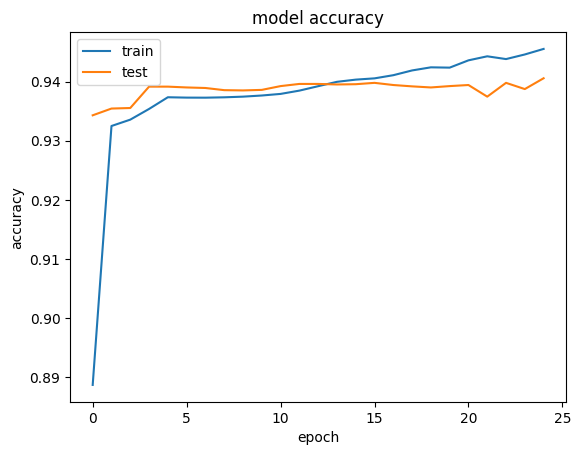

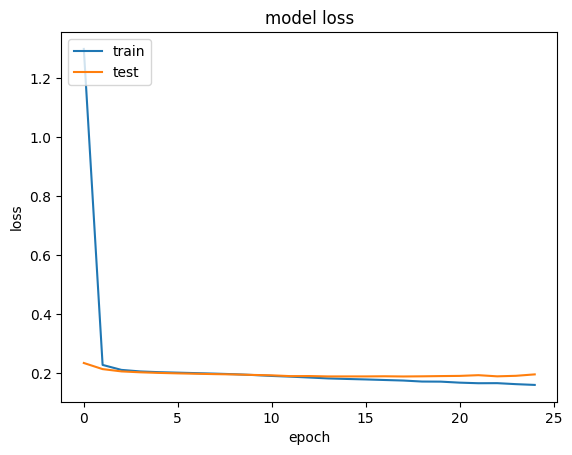

In [62]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Stanza Model Evaluation**

In [66]:
from stanza.models.common.doc import Document

test_sentences = decoded_test_input # List of Arabic sentences in your test set
test_tags = cleaned_test_tags  # Corresponding list of POS tags for the test sentences

# Process each sentence using Stanza and extract POS tags
stanza_predictions = []
for sentence in test_sentences:
    doc = nlp(sentence)
    stanza_tags = [word.upos for sent in doc.sentences for word in sent.words]
    stanza_predictions.append(stanza_tags)

# Now you can compare the Stanza predictions with your ground truth tags
correct_predictions = 0
total_predictions = 0

for i in range(len(stanza_predictions)):
    min_len = min(len(stanza_predictions[i]), len(test_tags[i]))
    for j in range(min_len):
        if stanza_predictions[i][j] == test_tags[i][j]:
            correct_predictions += 1
        total_predictions += 1

accuracy = correct_predictions / total_predictions

print("Accuracy: {:.2%}".format(accuracy))


Accuracy: 41.55%


 # NetworkX Representation

In [124]:
def create_graph(pos_tags):
    Graph = nx.Graph()

    # Add nodes for each unique POS tag
    unique_pos = set(pos_tags)
    for pos in unique_pos:
        Graph.add_node(pos)

    # Add edges between adjacent POS tags
    for i in range(len(pos_tags)-1):
        Graph.add_edge(pos_tags[i], pos_tags[i+1])


    return Graph

**Visualize the Network Graph**

In [157]:
def draw_graph(graph):
    plt.figure(figsize=(20, 10))

    pos = nx.spring_layout(graph)

    # Increase the distance between nodes
    pos = {node: (x, y + 2) for node, (x, y) in pos.items()}

    labels = nx.get_node_attributes(graph, 'pos_tag')

    # Modify node labels to handle Arabic text
    node_labels = {node: f"{get_display(arabic_reshaper.reshape(str(node[0])))}\n({labels.get(node, node[1])})" for node in graph.nodes()}

    nx.draw(graph, pos, with_labels=True, labels=node_labels, font_size=15, node_color='lightblue', edge_color='gray', width=1, alpha=0.7, node_size=1500)
    plt.title("Arabic Part Of Speech with NetworkX", fontsize=20, fontweight='bold')
    plt.axis('off')
    plt.show()


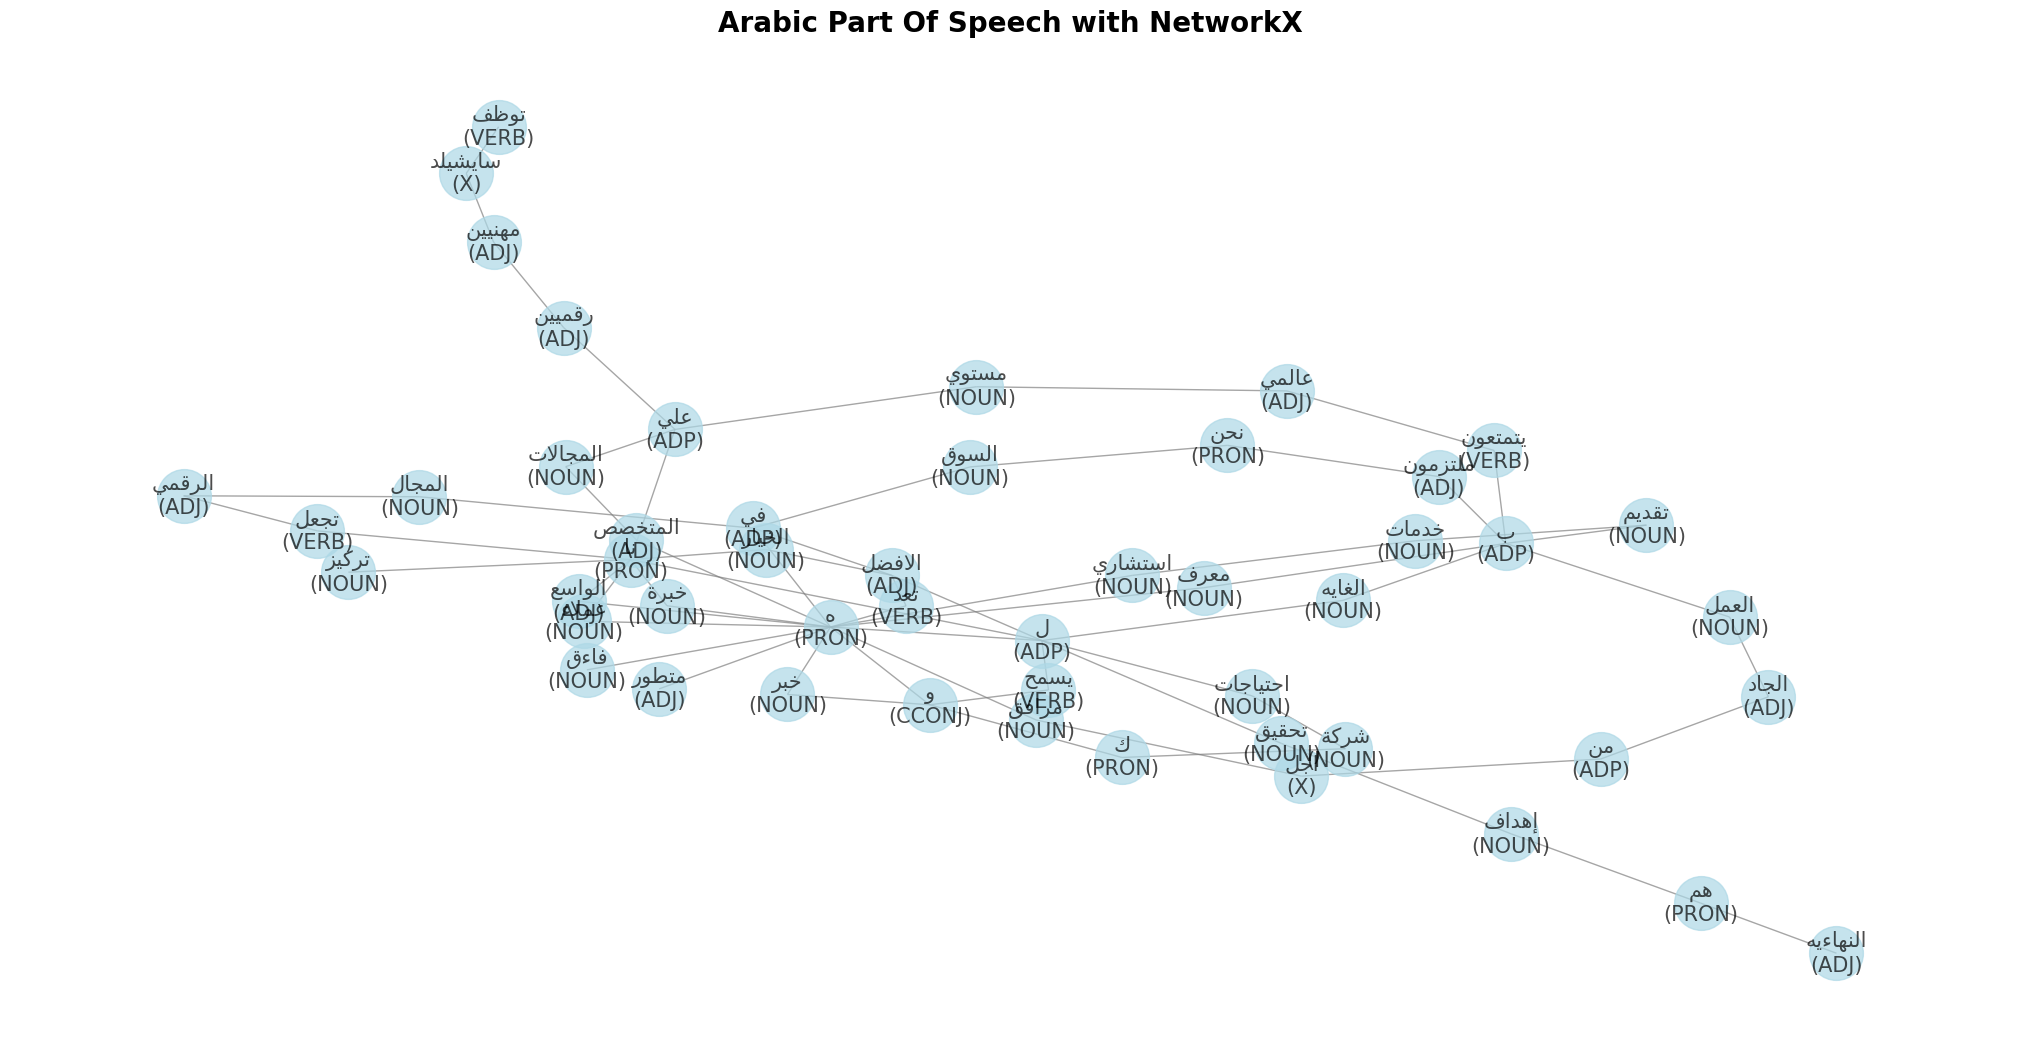

In [158]:
# Create and draw the graph
graph = create_graph(pos_tags)
draw_graph(graph)